<h1>Minesweeper</h1>

<h2>Libraries<h2>

In [1]:
%reload_ext blackcellmagic
%matplotlib notebook
%matplotlib inline

In [2]:
from IPython.display import display
from ipywidgets import IntSlider

import numpy as np
from numpy.random import default_rng
import math
from functools import reduce
from pprint import pprint
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from collections import Counter

from binarytree import Node


<h2>The Game</h2>

<h3>Set Up</h3>

In [3]:
size: np.ndarray = np.array([30, 16])
mines: int = 99

minefield: list = np.zeros(size + 2) + float("inf")
minefield[1:-1, 1:-1] = 0
rng: object = default_rng()

numbers = rng.choice(size[0] * size[1] - 1, size=mines, replace=False)
positions = np.array([np.floor(numbers / size[1]), numbers % size[1]]) + 1
for x, y in zip(positions[0], positions[1]):
    minefield[int(x), int(y)] = -9
    for i in range(-1, 2):
        for j in range(-1, 2):
            if minefield[int(x + i), int(y + j)] != -9:
                minefield[int(x + i), int(y + j)] -= 1

minefield[minefield == 0] = -float("inf")

prob = minefield < 0
prob = prob / mines
iteration = [np.abs(minefield)]

<h3>Playing</h3>

In [4]:
def pick(field, coords: tuple):
    x, y = coords
    if field[x, y] == -float("inf"):
        field[x, y] = 0
        field = clean(field, (x, y))
    elif field[x, y] < 0:
        field[x, y] *= -1
    if field[x, y] == 9:
        return field, "GAME OVER"
    return field, str(field[x, y])


def clean(field, coords):
    x, y = coords
    for i in range(-1, 2):
        for j in range(-1, 2):
            if field[x + i, y + j] == -float("inf"):
                field[x + i, y + j] = 0
                field = clean(field, (x + i, y + j))
            else:
                field[x + i, y + j] = abs(field[x + i, y + j])
    return field


def goodStart(field):
    shape = np.shape(field)
    maxDensity = 0
    coords = (0, 0)
    for i in range(0, shape[0] - 2):
        for j in range(0, shape[1] - 2):
            density = np.count_nonzero(field[i : i + 3, j : j + 3] == -float("inf"))
            if density >= maxDensity:
                maxDensity = density
                coords = (i + 1, j + 1)
    return coords

In [5]:
def solve(minefield, mines, probability):
    shape: tuple = np.shape(minefield)
    prob = probability * (minefield < 0)
    progBar = IntSlider(min=0, max=(
        shape[0]-2)*(shape[1]-2), readout=True, readout_format='d')
    display(progBar)
    
    def getInterest(prob):
        shape: tuple = np.shape(prob)
        interest: list = []
        for x in range(1, shape[0] - 1):
            for y in range(1, shape[1] - 1):
                grid = prob[x - 1 : x + 2, y - 1 : y + 2]
                if (
                    prob[x, y] == 0
                    and np.count_nonzero(np.logical_and(grid < 1, grid > 0)) >= 1
                ):
                    interest.append((x, y))
        return interest

    def getTrial(field, prob):
        shape: tuple = np.shape(prob)
        trialers: list = []
        for x in range(1, shape[0] - 1):
            for y in range(1, shape[1] - 1):
                grid = field[x - 1 : x + 2, y - 1 : y + 2]
                if (
                    0 < prob[x, y] < 1
                    and np.count_nonzero(np.logical_and(grid >= 0, grid <= 9)) > 0
                ):
                    trialers.append((x, y))
        return trialers

    def quickFinish(field, prob, mines):
        shape: tuple = np.shape(field)
        minesLeft = mines - np.count_nonzero(prob == 1)
        if minesLeft == 0:
            for x in range(1, shape[0] - 1):
                for y in range(1, shape[1] - 1):
                    if 0 < prob[x, y] < 1:
                        field, msg = pick(field, (x, y))
                        if msg == "GAME OVER":
                            raise Exception
        elif minesLeft == np.count_nonzero(field < 0):
            prob[prob > 0] = 1

        prob[field >= 0] = 0
        if np.count_nonzero(minefield == 9):
            raise Exception
        progBar.value = np.count_nonzero(np.logical_or(
            prob[1:-1, 1:-1] == 0, prob[1:-1, 1:-1] == 1))
        return field, prob

    def easy(minefield, shape, prob, mines):
        state = 0
        interest = getInterest(prob)
        for x, y in interest:
            grid = prob[x - 1 : x + 2, y - 1 : y + 2]
            if (
                np.count_nonzero(grid == 1) == minefield[x, y]
                and np.count_nonzero(grid > 0) > minefield[x, y]
            ):
                state = 1
                for i in range(-1, 2):
                    for j in range(-1, 2):
                        if 0 < prob[x + i, y + j] < 1:
                            minefield, msg = pick(minefield, (x + i, y + j))
                            prob[minefield >= 0] = 0
            elif (
                np.count_nonzero(np.logical_and(grid > 0, grid < 1))
                + np.count_nonzero(grid == 1)
                == minefield[x, y]
                and np.count_nonzero(grid == 1) != minefield[x, y]
            ):
                state = 1
                grid[grid > 0] = 1
            elif np.count_nonzero(minefield == 9) > 0:
                raise Exception
            progBar.value = np.count_nonzero(np.logical_or(
                prob[1:-1, 1:-1] == 0, prob[1:-1, 1:-1] == 1))
        minefield, prob = quickFinish(minefield, prob, mines)
        
        if state == 1:
            return easy(minefield, shape, prob, mines)
        elif np.count_nonzero(prob == 1) == mines:
            return minefield, prob
        else:
            return stage2(minefield, mines, prob)

    def stage2(minefield, mines, prob):
        def flip(minefield, prob, base, trialLen):
            if base < trialLen/2 or base >= 3 * trialLen/4:
                minefield = np.fliplr(minefield)
                prob = np.fliplr(prob)
            if trialLen/2 <= base:
                minefield = np.flipud(minefield)
                prob = np.flipud(prob)
            return(minefield, prob)
            
        shape: tuple = np.shape(minefield)
        trial: list = getTrial(minefield, prob)
        investigate: list = [[], []]
        last: list = [[1], [prob]]
        base: int = 0
        while True:
            for index, field in zip(last[0], last[1]):
                for i in range(2):

                    tempMap = np.array(field)
                    tempMap[trial[base]] = i

                    def check(field, prob, mines):
                        if mines < np.count_nonzero(prob == 1):
                            return False
                        if mines > (np.count_nonzero(np.logical_and(prob < 1, prob > 0)) + np.count_nonzero(prob == 1)):
                            return False
                        for x in range(1, shape[0] - 1):
                            for y in range(1, shape[1] - 1):
                                if field[x, y] > 0:
                                    grid = prob[x - 1 : x + 2, y - 1 : y + 2]
                                    if np.count_nonzero(grid == 1) > field[x, y]:
                                        return False
                                    if np.count_nonzero(grid > 0) < field[x, y]:
                                        return False
                        return True

                    if check(minefield, tempMap, mines):
                        investigate[0].append((index << 1) + i)
                        investigate[1].append(tempMap)
            print(
                f"\rNo: {len(investigate[0])}, Lvl: {base}, Red: {2**(base+1) - len(investigate[0])}, itRed: {(len(last[0])<<1) - len(investigate[0])}, Max Lvl: {len(trial)-1}", end = ""
            )
            ands = reduce(lambda a, b: a & b, investigate[0])
            ors = reduce(lambda a, b: a | b, investigate[0])
            ands = bin(ands)[3:]
            ors = bin(ors)[3:]
            if ands.count("1") > 0:
                for j, a in enumerate(ands):
                    if a == "1":
                        prob[trial[j]] = 1
                if base > len(trial)/4:
                    minefield, prob = flip(minefield, prob, base, len(trial))
                progBar.value = np.count_nonzero(np.logical_or(
                    prob[1:-1, 1:-1] == 0, prob[1:-1, 1:-1] == 1))
                return easy(minefield, shape, prob, mines)
            elif ors.count("0") > 0:
                for j, o in enumerate(ors):
                    if o == "0":
                        pick(minefield, trial[j])
                prob[minefield >= 0] = 0 
                if base > len(trial)/4:
                    minefield, prob = flip(minefield, prob, base, len(trial))
                progBar.value = np.count_nonzero(np.logical_or(
                    prob[1:-1, 1:-1] == 0, prob[1:-1, 1:-1] == 1))
                return easy(minefield, shape, prob, mines)

            if base + 1 == len(trial):
                return stage3(minefield, mines, prob, investigate[0], trial)
    
            base += 1
            last = list(investigate)
            investigate = [[], []]

    def stage3(minefield, mines, prob, finalPossibilites, trial):
        binary = np.array([list(bin(i)[3:]) for i in finalPossibilites])
        shape: tuple = np.shape(minefield)
        count = np.count_nonzero(binary == "1", axis=1)
        minesLeft: int = mines - np.count_nonzero(prob == 1)
        if minesLeft == min(count) and np.count_nonzero(np.logical_and(prob>0, prob<1)) != len(trial):
            for x in range(1, shape[0] - 1):
                for y in range(1, shape[1] - 1):
                    if 0 < prob[x, y] < 1 and not ((x, y) in trial):
                        pick(minefield, (x, y))
            prob[minefield >= 0] = 0
            progBar.value = np.count_nonzero(np.logical_or(
                prob[1:-1, 1:-1] == 0, prob[1:-1, 1:-1] == 1))
            return easy(minefield, shape, prob, mines)

        vertCount = np.count_nonzero(binary == "1", axis=0)
        countDistribution = Counter(count)
        
        averageNo = np.mean(count)
        chanceDarkness = (mines - averageNo - np.count_nonzero(prob == 1))/(np.count_nonzero(np.logical_and(prob>0, prob<1))-len(trial))
        chancePerSquare = vertCount / len(count)
        prob[np.logical_and(prob > 0, prob < 1)] = chanceDarkness
        for c, xy in zip(chancePerSquare, trial):
            prob[xy] = c

        coords = np.where(np.logical_and(prob == np.amin(prob[prob != 0]), prob<1))
        print(f"\nGUESS, chance: {prob[coords[0][0],coords[1][0]]}")
        minefield, msg = pick(minefield, (coords[0][0],coords[1][0]))
        prob[minefield == 0] = 0
        progBar.value = np.count_nonzero(np.logical_or(prob[1:-1, 1:-1] == 0, prob[1:-1, 1:-1] == 1))
        if msg == "GAME OVER":
            print(f"\n{msg}")
            progBar.value = np.size(prob[1:-1, 1:-1])
            return minefield, prob
        else:
            return easy(minefield, shape, prob, mines)
        print(countDistribution)
    
    progBar.value=np.count_nonzero(np.logical_or(prob[1:-1, 1:-1] == 0, prob[1:-1, 1:-1] == 1))
    minefield, prob = easy(minefield, shape, prob, mines)
    if np.count_nonzero(minefield == 9) == 0:
        print("\nWIN")
    return minefield, prob

In [6]:
def present(field, axis):
    shape = np.shape(field)
    img = np.zeros([*shape, 3])
    img[np.logical_or(field == 0, field == float("inf")), :] = [
        256, 256, 256]  # White
    img[field == 1, :] = [175, 175, 256]  # Light Blue
    img[field == 2, :] = [175, 256, 175]  # Light Green
    img[field == 3, :] = [256, 175, 175]  # Light Red
    img[field == 4, :] = [0, 0, 256]  # Blue
    img[field == 5, :] = [256, 0, 0]  # Red
    img[field == 6, :] = [0, 256, 0]  # Green
    img[field == 7, :] = [200, 60, 200]  # Purple
    img[field == 8, :] = [250, 150, 0]  # Orange
    img[field == 9, :] = [150, 0, 0]  # Brown
    img[field == 10, :] = [150, 20, 147]  # Dark Purple
    img = img / 256
    axis.xaxis.set_ticks([])
    axis.yaxis.set_ticks([])
    axis.imshow(img)
    

def imgArray(field):
    shape = np.shape(field)
    img = np.zeros([*shape, 3])
    img[np.logical_or(field == 0, field == float("inf")), :] = [
        256, 256, 256]  # White
    img[field == 1, :] = [175, 175, 256]  # Light Blue
    img[field == 2, :] = [175, 256, 175]  # Light Green
    img[field == 3, :] = [256, 175, 175]  # Light Red
    img[field == 4, :] = [0, 0, 256]  # Blue
    img[field == 5, :] = [256, 0, 0]  # Red
    img[field == 6, :] = [0, 256, 0]  # Green
    img[field == 7, :] = [200, 60, 200]  # Purple
    img[field == 8, :] = [250, 150, 0]  # Orange
    img[field == 9, :] = [150, 0, 0]  # Brown
    img[field == 10, :] = [150, 20, 147]  # Dark Purple
    img = img / 256
    
    return img
    
def draw(axis, field, image = None):
    img = imgArray(field)
    if image is None:
        image = axis.imshow(img)
    else:
        image.data = img
    axis.draw()
    return image


IntSlider(value=0, max=480)

No: 12, Lvl: 11, Red: 4084, itRed: 12, Max Lvl: 11
GUESS, chance: 0.11029411764705882

GAME OVER


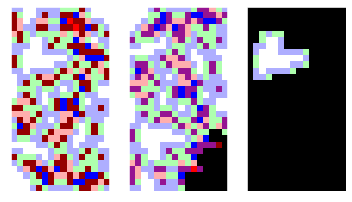

In [7]:

#ax0 = plt.Axes()
#print(ax0)
#img = draw(ax0, minefield)

coords = goodStart(minefield)
minefield, _ = pick(minefield, coords)
#img = draw(ax0, minefield, img)
iteration.append(np.array(minefield))

minefield, prob = solve(minefield, mines, prob)
iteration.append(np.array(minefield))
iteration[-1][prob == 1] = 10

flashbacks = min(5, len(iteration))
figure, axis=plt.subplots(1, flashbacks)
for i in range(0, -flashbacks, -1):
    if flashbacks == 1:
        present(iteration[i][1:-1, 1:-1], axis)
    else:
        present(iteration[i][1:-1, 1:-1], axis[-i])


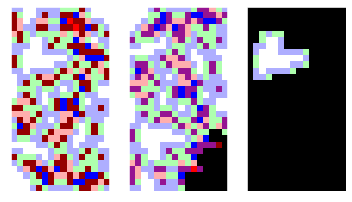

In [8]:
flashbacks = min(5, len(iteration))
figure, axis = plt.subplots(1, flashbacks)
for i in range(0, -flashbacks, -1):
    if flashbacks == 1:
        present(iteration[i][1:-1, 1:-1], axis)
    else:
        present(iteration[i][1:-1, 1:-1], axis[-i])

In [9]:
1/17

0.058823529411764705